In [1]:
import itertools
import math
import os
import pickle

from keras.constraints import max_norm
from keras.layers import Conv2D, Input, MaxPooling2D, AveragePooling2D, Dropout, UpSampling2D, Concatenate, GaussianNoise
from scipy import interpolate
from sklearn import metrics
import keras
import keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tqdm

%matplotlib inline

Using TensorFlow backend.


In [2]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999

<IPython.core.display.Javascript object>

In [3]:
# Notebook settings.
pd.set_option('display.max_rows', 200)
pd.set_option('mode.chained_assignment', 'raise')

In [4]:
# Settings.
RESOLUTION = '500'
TARGET_NAME = 'lst_night_mean'
CITY_NAMES = ['bal', 'det', 'phx', 'por']
CELL_SIZE = 32

In [5]:
# Helper functions.

def fill_nan_mean(a):
    a = np.copy(a)
    a[np.isnan(a)] = np.nanmean(a)
    return a

def interpolate_nan_2d(a):
    x = np.arange(0, a.shape[1])
    y = np.arange(0, a.shape[0])
    a = np.ma.masked_invalid(a)
    xx, yy = np.meshgrid(x, y)
    x1 = xx[~a.mask]
    y1 = yy[~a.mask]
    newarr = a[~a.mask]
    return interpolate.griddata((x1, y1), newarr.ravel(),(xx, yy), method='linear')

def extrapolate_nan_2d(a):
    a = a.copy()
    median = np.median(a[np.isfinite(a)])
    for corner in [(0, 0), (0, -1), (-1, 0), (-1, -1)]:
        if np.isnan(a[corner]):
            a[corner] = median
    return interpolate_nan_2d(a)

def fill_nan_interpolate(a, i=0):
    result = extrapolate_nan_2d(interpolate_nan_2d(a))
    if np.isnan(result).sum() > 0:
        print('Warning: rerunning interpolation {}'.format(i))
        return fill_nan_interpolate(result, i=i+1)
    else:
        return result

In [6]:
# Read data for all cities.
with open('../../../data/image-grid-channels_{}.p'.format(RESOLUTION), 'rb') as f:
    IMAGE_GRID_CHANNELS = pickle.load(f)

img_cities = []
for city in CITY_NAMES:
    path = '../../../data/image-grid_{}_{}.npy'.format(RESOLUTION, city)
    img = np.load(path)
    assert img.shape[2] == len(IMAGE_GRID_CHANNELS)
    img_cities.append(img)

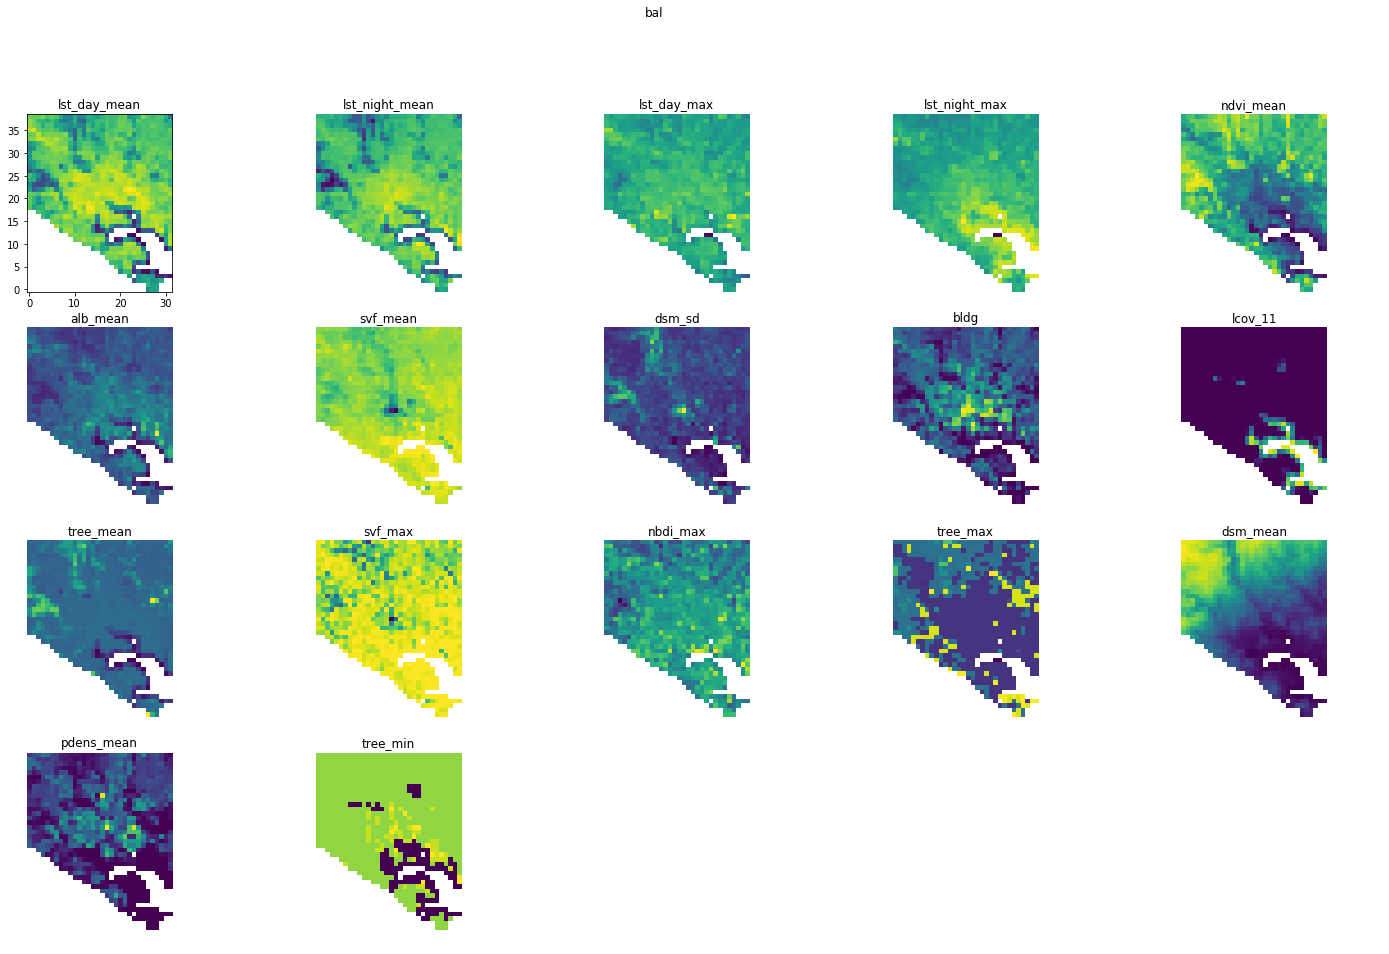

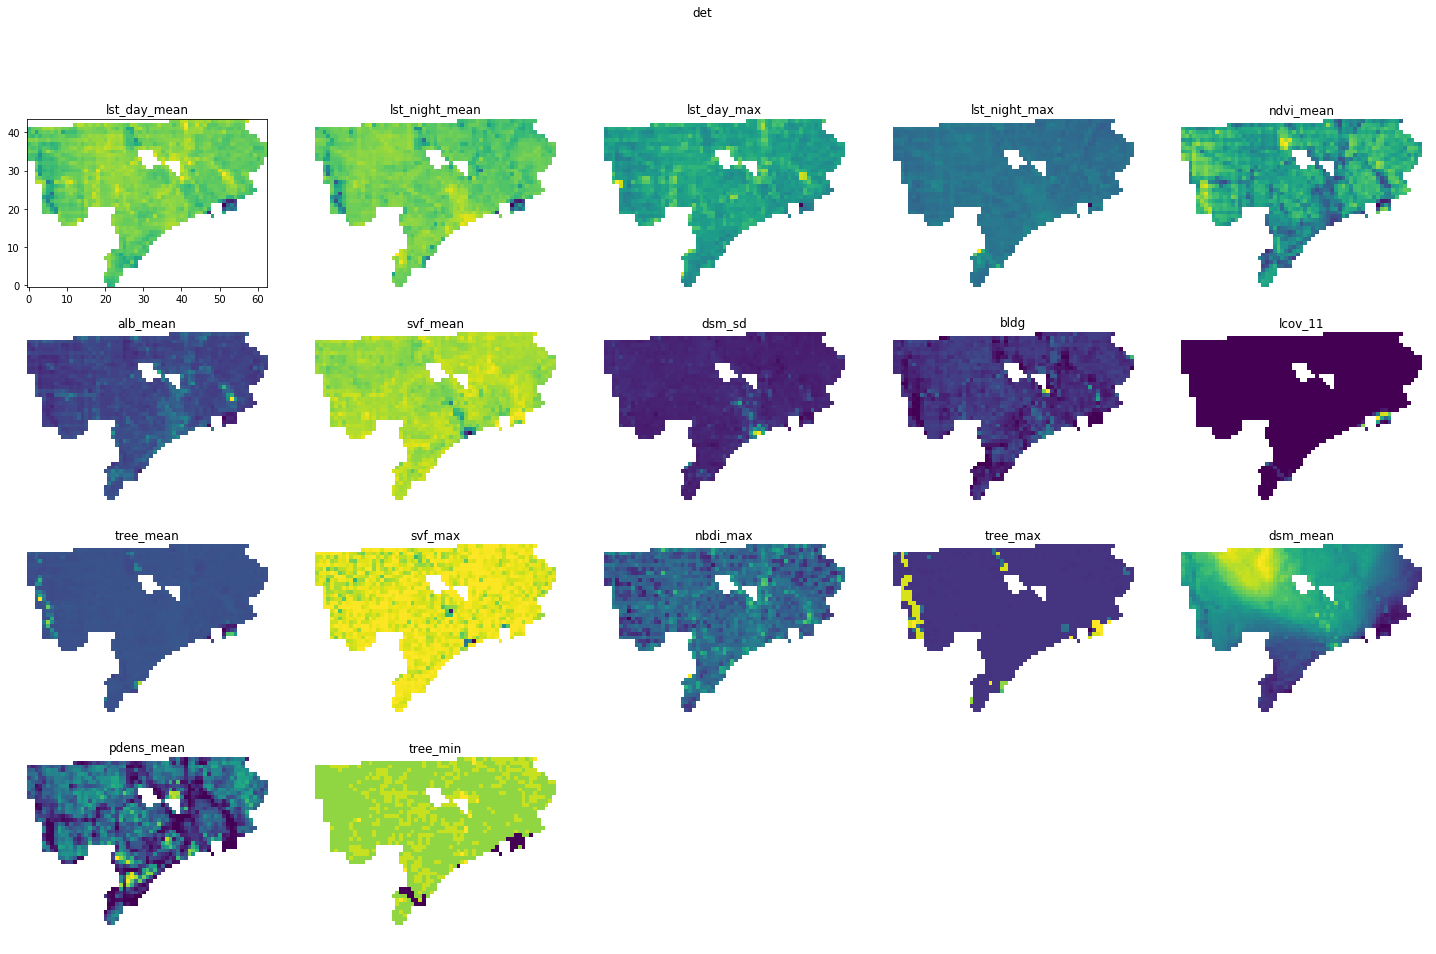

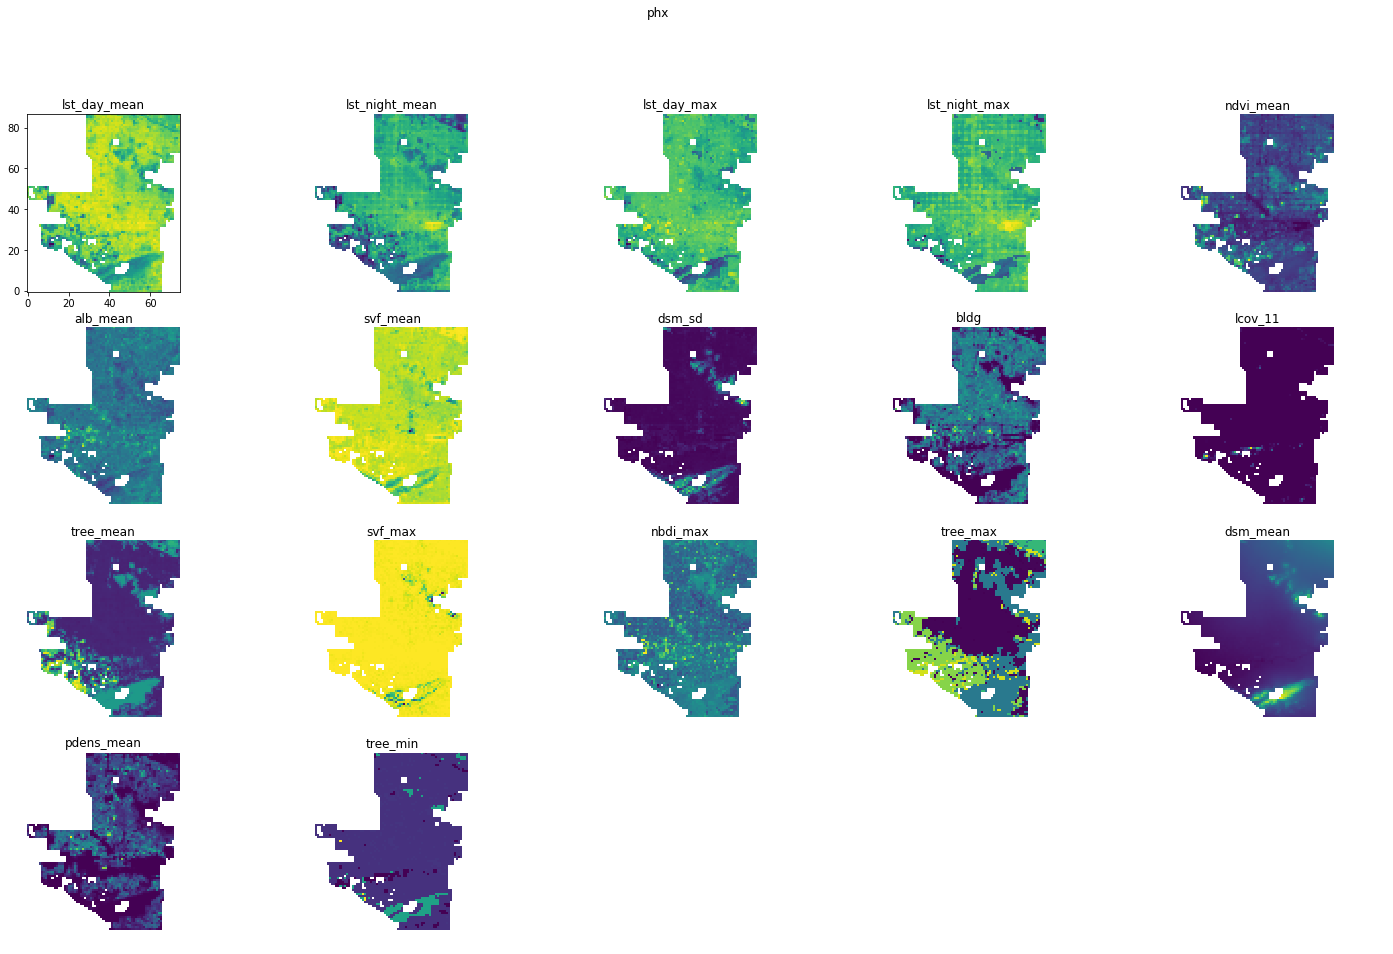

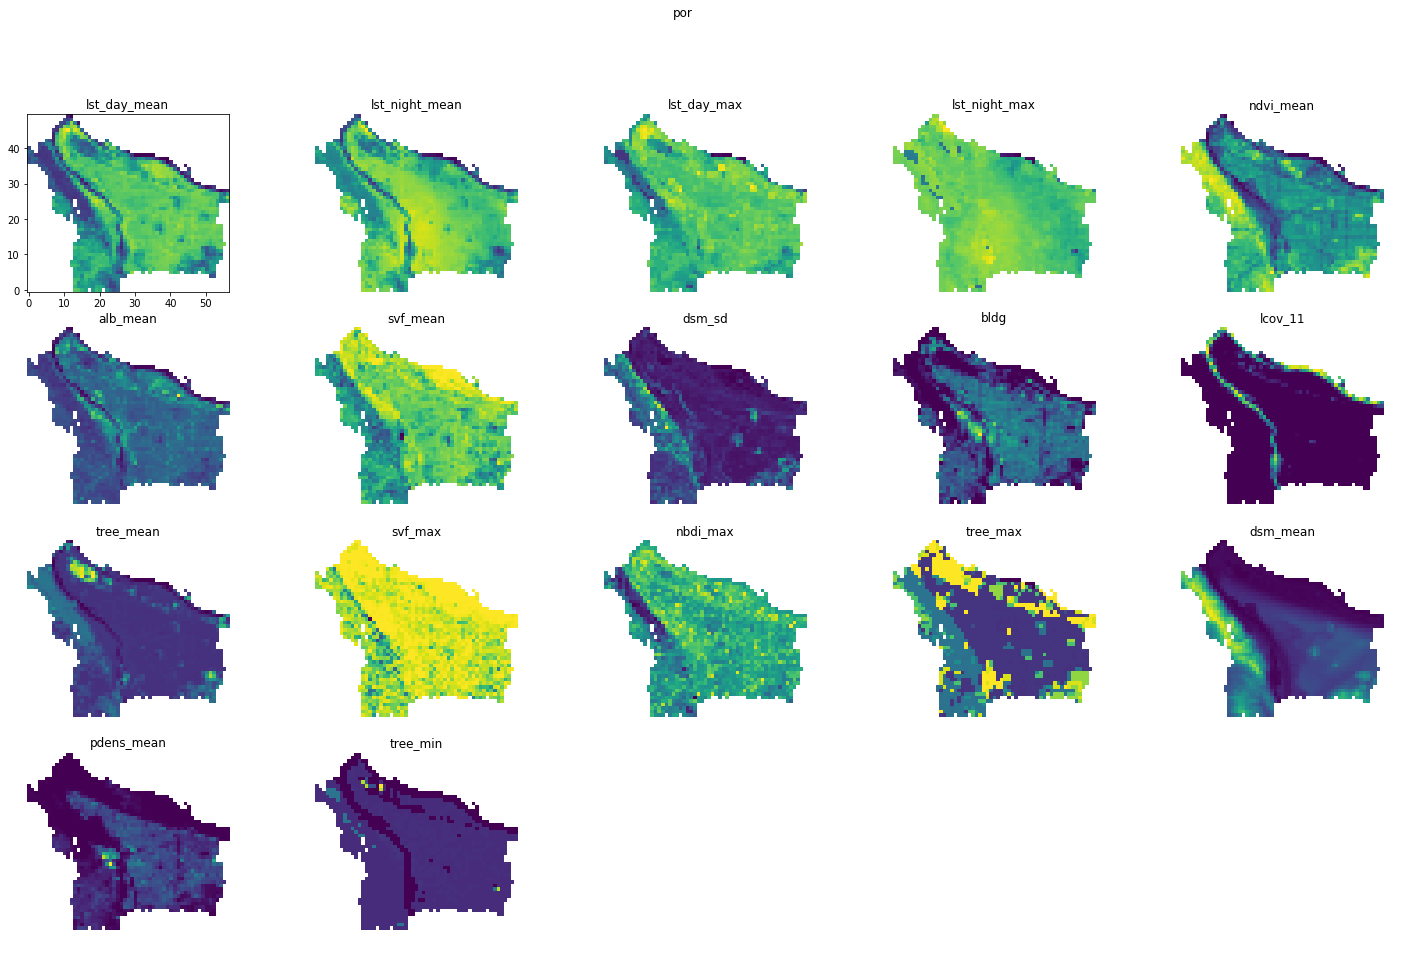

In [7]:
# View the channels for each city.
for city_name, img in zip(CITY_NAMES, img_cities):
    n_cols = 5
    cols = [x for x in IMAGE_GRID_CHANNELS if x not in {'x', 'y'}]
    n_rows = math.ceil(len(IMAGE_GRID_CHANNELS) / n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(25, 15))
    fig.suptitle(city_name)
    for name, ax in zip(cols, axes.flatten()):
        ax.imshow(img[:, :, IMAGE_GRID_CHANNELS.index(name)], origin='lower')
        ax.set_title(name)
        
    # Hide other axes.
    for i in range(1, n_rows*n_cols):
        axes.flatten()[i].axis('off')


In [8]:
img_x_cities = []
img_y_cities = []

for img in img_cities:

    # Choose x & y.
    other_target_names = [c for c in IMAGE_GRID_CHANNELS if c != TARGET_NAME and c.startswith('lst')]
    cols_to_drop = [TARGET_NAME, 'x', 'y'] + other_target_names
    img_cols = [c for c in IMAGE_GRID_CHANNELS if c not in cols_to_drop]

    # Pad to multiple of cell size.
    img_size = np.array(img.shape[:2])
    n_cells = np.ceil(img_size / CELL_SIZE).astype(int)
    padded_img_size = n_cells * CELL_SIZE
    pad_n = ((padded_img_size - img_size) // 2).astype(int)
    pad_s = (padded_img_size - img_size) - pad_n
    img_padded = np.pad(img, [(pad_n[0], pad_s[0]), (pad_n[1], pad_s[1]), (0, 0)], mode='constant', constant_values=np.nan)

    # Subset the data.
    img_x = np.delete(img_padded, [IMAGE_GRID_CHANNELS.index(c) for c in cols_to_drop], axis=2).copy()
    img_y = img_padded[:, :, IMAGE_GRID_CHANNELS.index(TARGET_NAME)].copy()

    # If the target is missing.
    has_data = (~np.isnan(img_y)).astype(int)
    img_x = np.dstack([img_x, has_data])
    img_cols.append('target_has_data')

    # Interpolate missing data.
    img_y = fill_nan_interpolate(img_y)
    for i in range(len(img_cols)):
        img_x[:, :, i] = fill_nan_interpolate(img_x[:, :, i])
        
    # Save results.
    img_x_cities.append(img_x)
    img_y_cities.append(img_y)

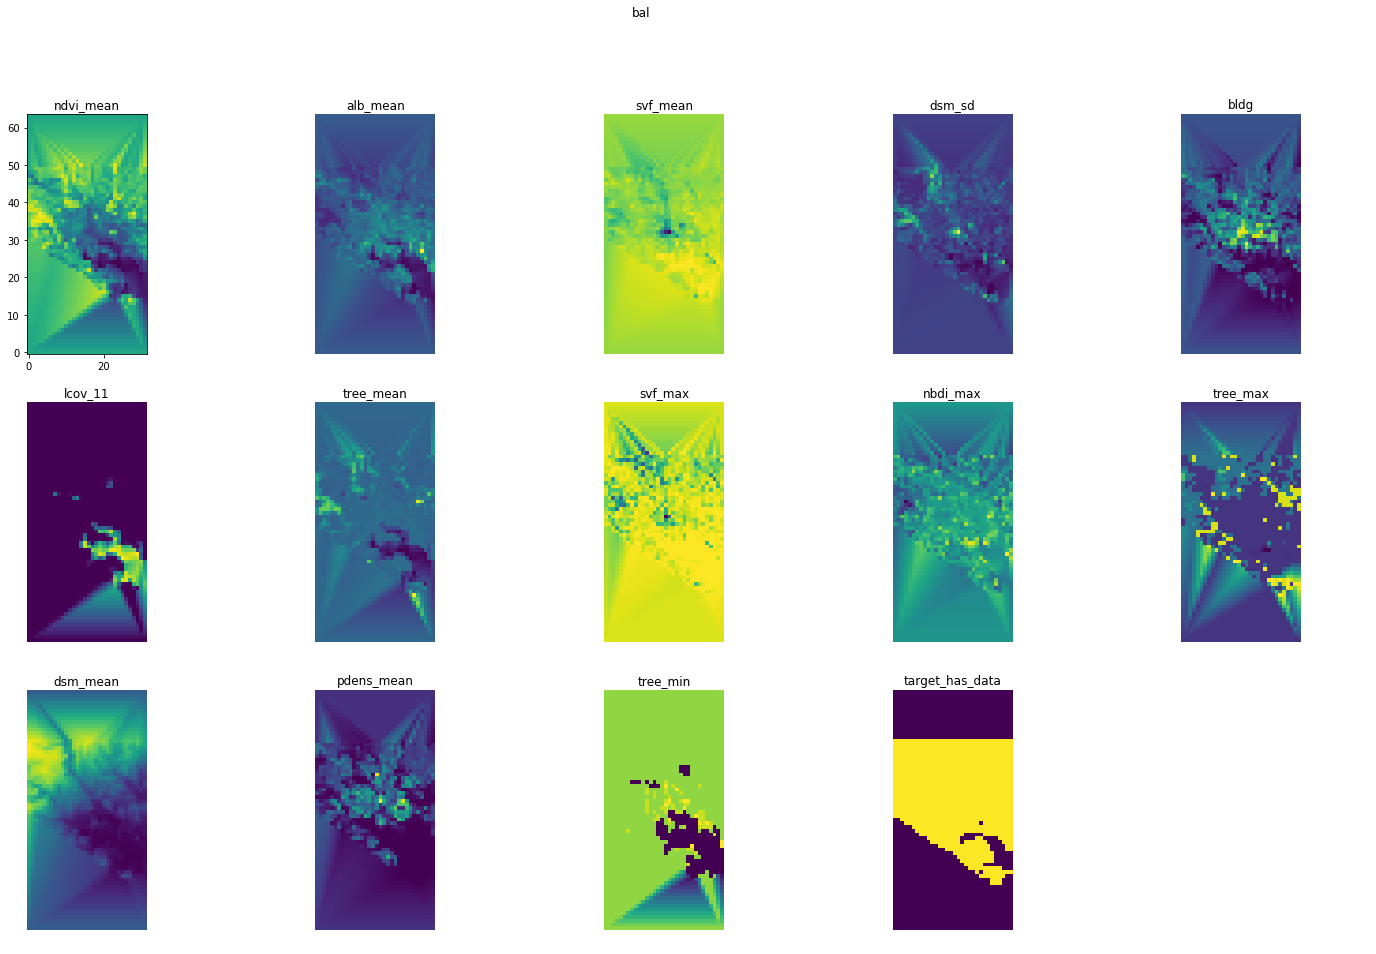

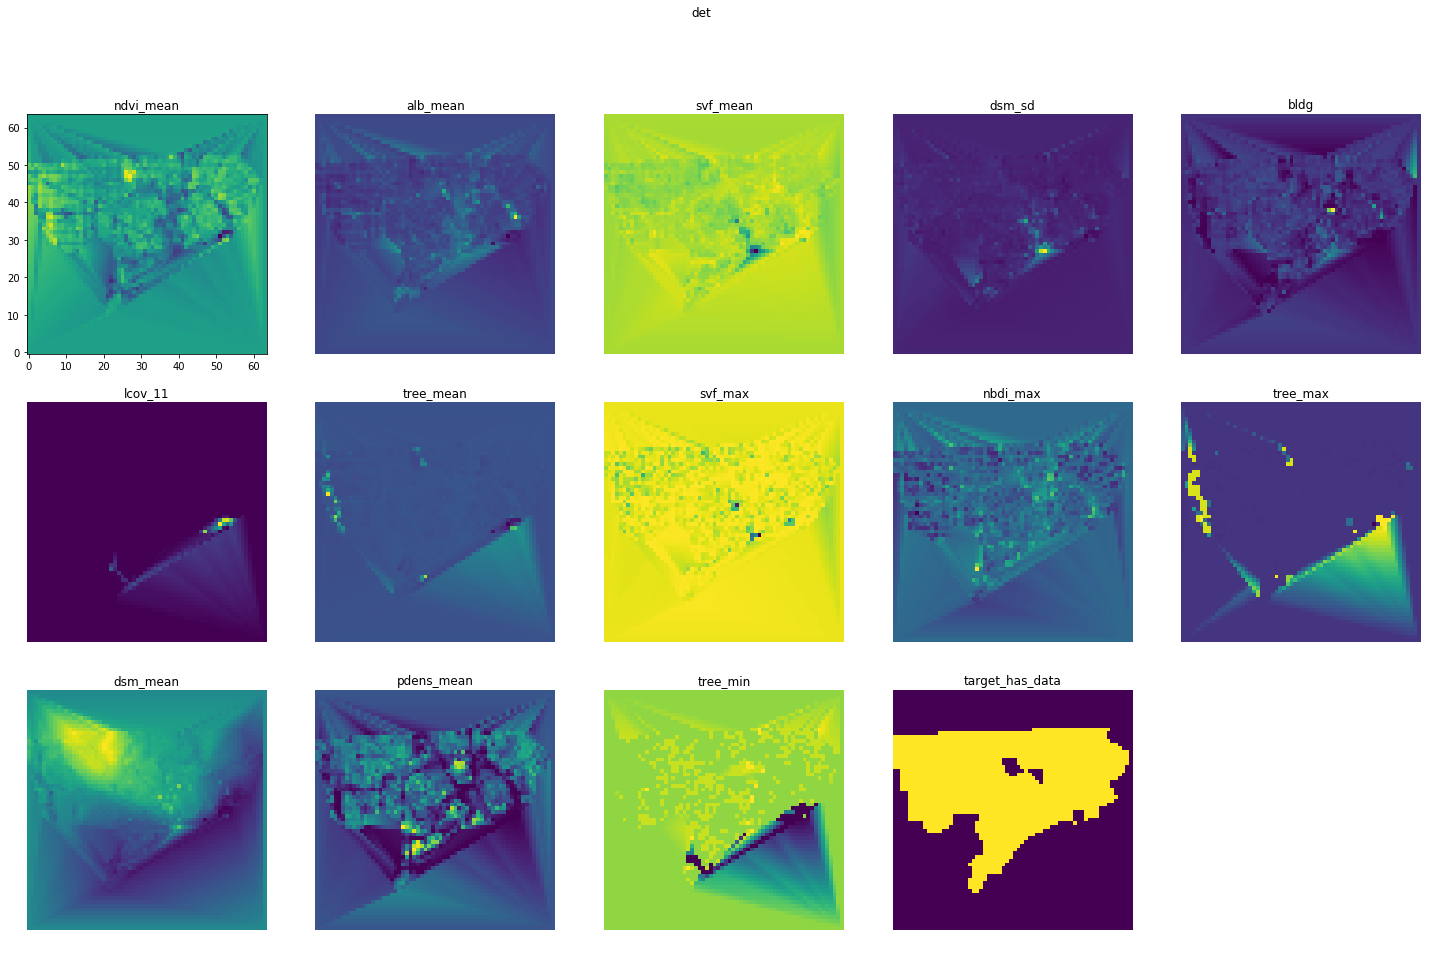

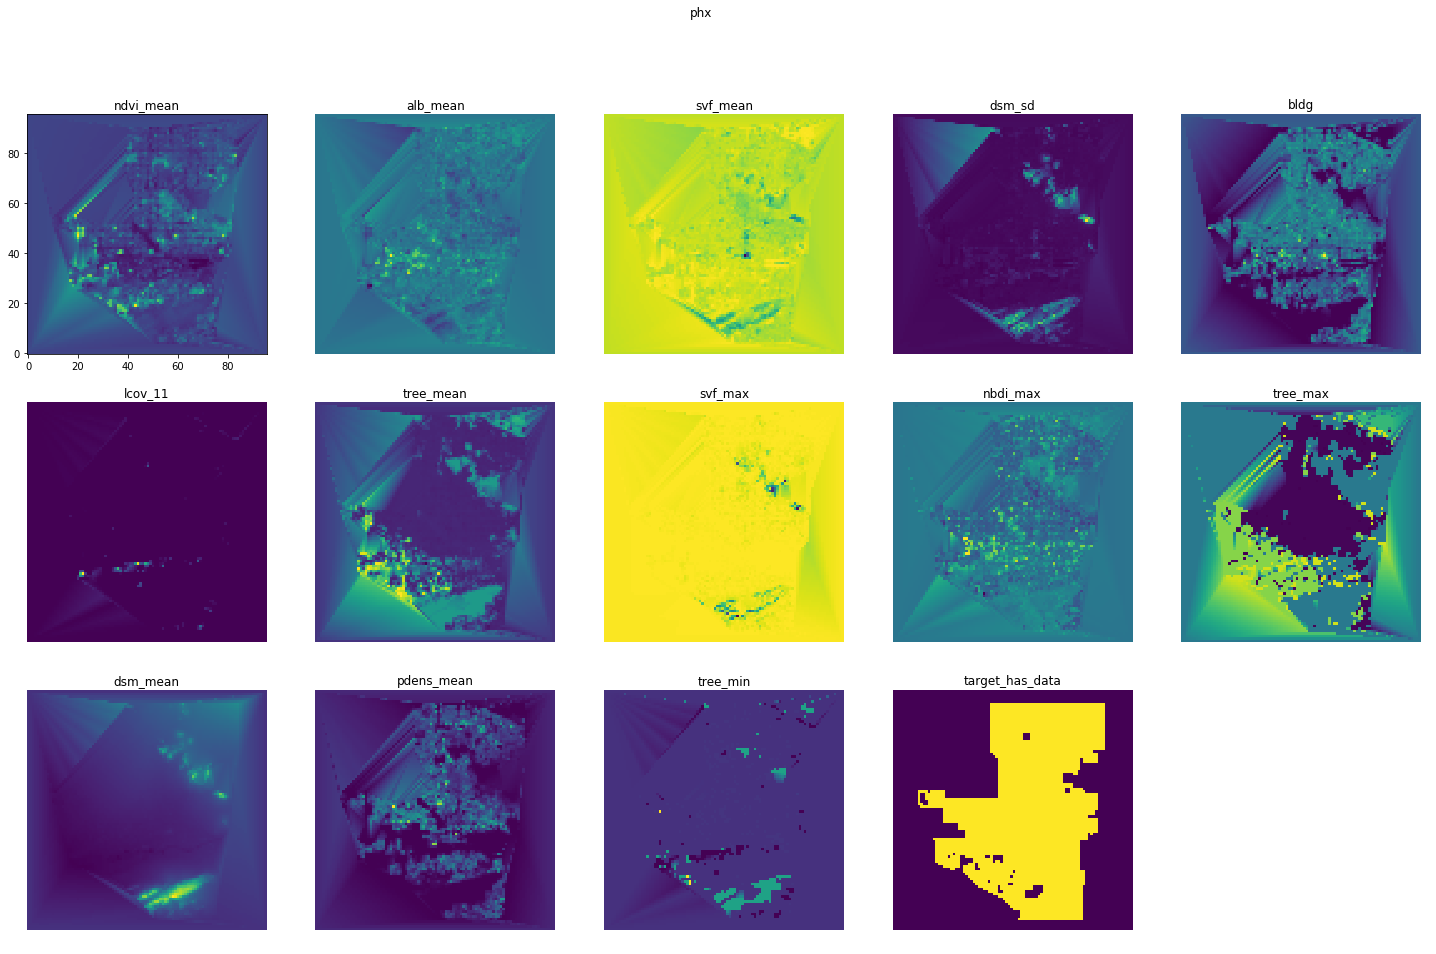

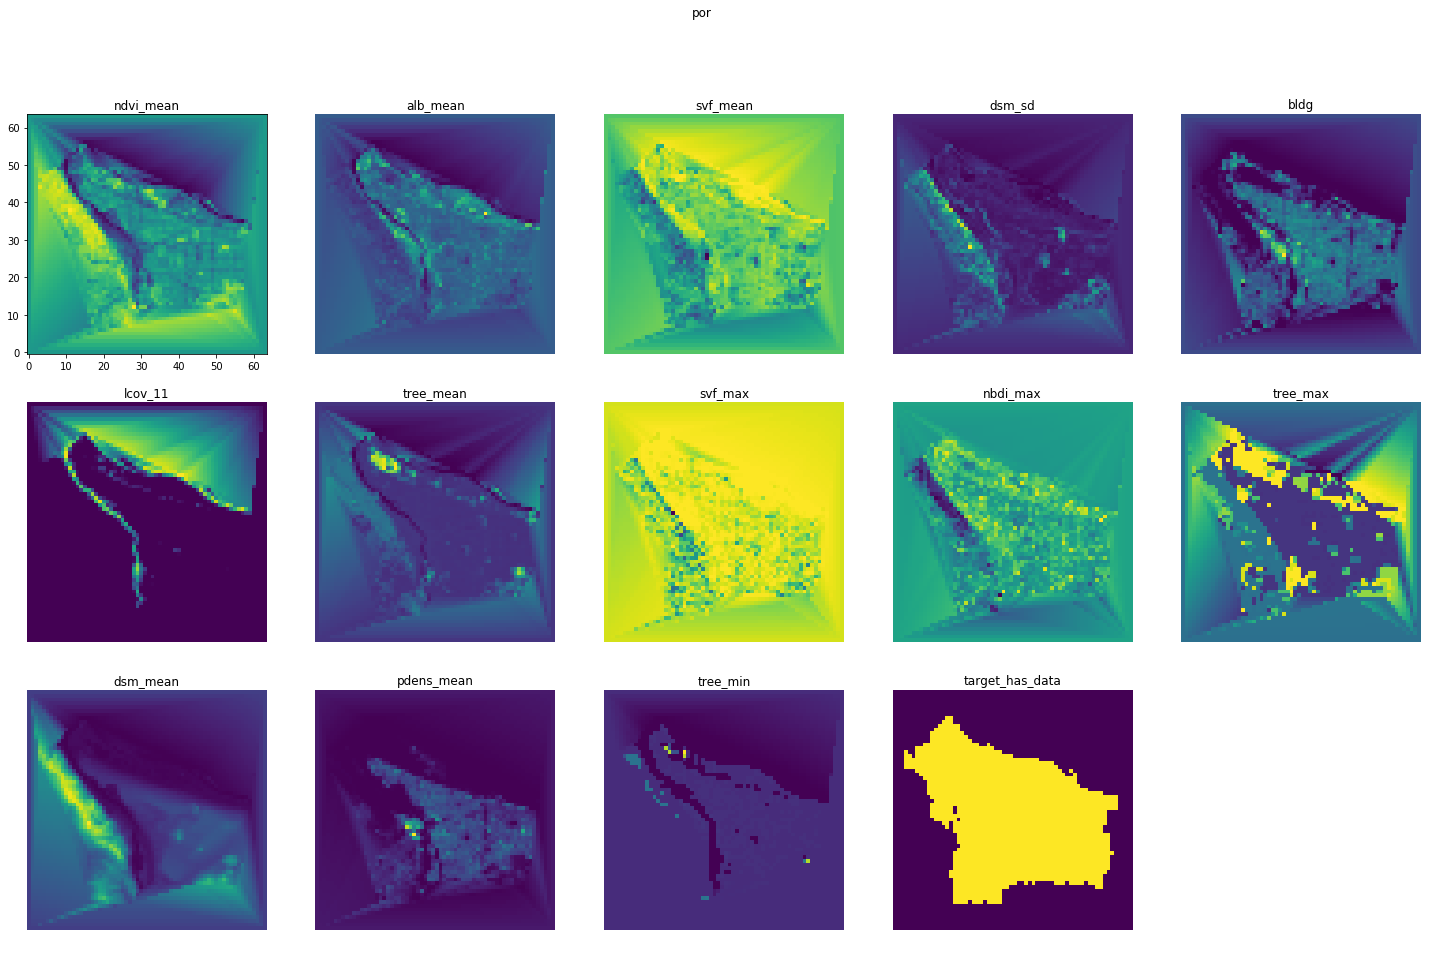

In [9]:
# View the interpolated channels.
n_cols = 5
n_rows = math.ceil(len(img_cols) / n_cols)

for city_name, img_x, img_y in zip(CITY_NAMES, img_x_cities, img_y_cities):
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(25, 15))
    fig.suptitle(city_name)
    
    plt_img = img
    
    for name, ax in zip(img_cols, axes.flatten()):
        ax.imshow(img_x[:, :, img_cols.index(name)], origin='lower')
        ax.set_title(name)
        
    for i in range(1, n_rows*n_cols):
        axes.flatten()[i].axis('off')

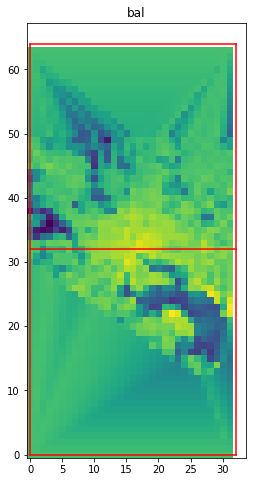

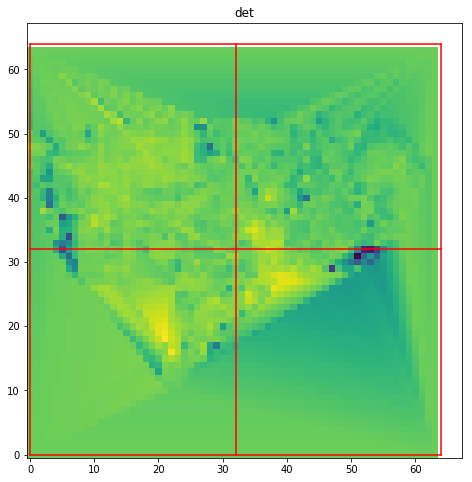

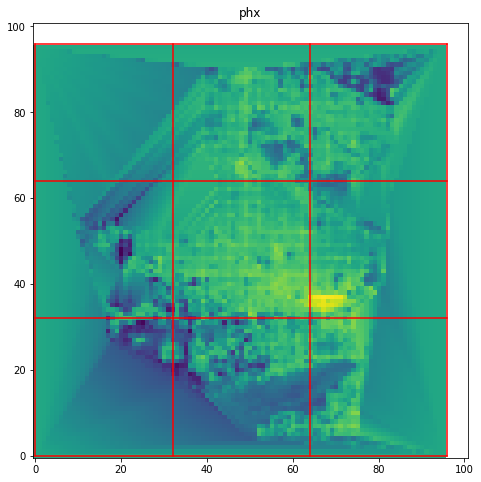

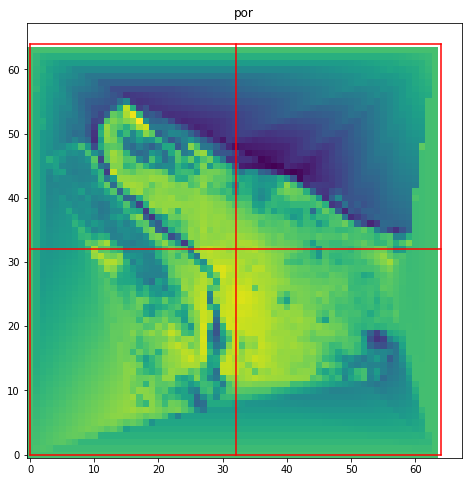

In [10]:
# Convert to samples representation. We'll represent each subgrid by the coords of the top-left corner.
cell_x_cities = []
cell_y_cities = []

cell_data_x = []
cell_data_y = []
cell_data_loc = []
cell_data_city_name = []

for img, img_x, img_y, city_name in zip(img_cities, img_x_cities, img_y_cities, CITY_NAMES):


    cell_x = np.arange(0, img.shape[1], CELL_SIZE)
    cell_y = np.arange(0, img.shape[0], CELL_SIZE)

    # Plot grid.
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(img_y, origin='lower')


    cell_x_lines = list(cell_x) + [cell_x[-1] + CELL_SIZE]
    cell_y_lines = list(cell_y) + [cell_y[-1] + CELL_SIZE]

    for x in cell_x_lines:
        ax.plot([x, x], [min(cell_y_lines), max(cell_y_lines)], 'r')
    for y in cell_y_lines:
        ax.plot([min(cell_x_lines), max(cell_x_lines)], [y, y], 'r')
        
    ax.set_title(city_name)
    
    cell_x_cities.append(cell_x)
    cell_y_cities.append(cell_y)
    
    # # Split into cells.
    # cell_data_x = []
    # cell_data_y = []
    # cell_data_loc = []

    for x, y in list(itertools.product(cell_x, cell_y)):
        cell_data_x.append(img_x.swapaxes(0,1)[x:x+CELL_SIZE, y:y+CELL_SIZE, :].swapaxes(0,1))
        cell_data_y.append(img_y.swapaxes(0,1)[x:x+CELL_SIZE, y:y+CELL_SIZE].T)
        cell_data_loc.append((x, y))
        cell_data_city_name.append(city_name)

# Remove cells that are just all missing.
cell_nan_frac = [1-a[:, :, -1].mean() for a in cell_data_x]
keep_cell = [x < 1 for x in cell_nan_frac]
cell_data_x = list(itertools.compress(cell_data_x, keep_cell))
cell_data_y = list(itertools.compress(cell_data_y, keep_cell))
cell_data_loc = list(itertools.compress(cell_data_loc, keep_cell))
cell_data_city_name = list(itertools.compress(cell_data_city_name, keep_cell))

In [11]:
# Model data.
x_nn = np.array(cell_data_x)
y_nn = np.array(cell_data_y)[..., np.newaxis]
print(x_nn.shape)
print(y_nn.shape)

(18, 32, 32, 14)
(18, 32, 32, 1)


In [12]:
# Model.
def get_model():
    # Initialise final layer bias to speed initial training.
    bias_init = keras.initializers.TruncatedNormal(mean=y_nn.mean(), stddev=y_nn.std())
    
    inputs = Input(x_nn[0].shape, name='x')
    noise = GaussianNoise(stddev=0.2)(inputs)
    conv_1 = Conv2D(16, 3, activation='relu', padding='same', kernel_constraint=max_norm(3), bias_constraint=max_norm(3))(noise)
    conv_2 = Conv2D(16, 3, activation='relu', padding='same', kernel_constraint=max_norm(3), bias_constraint=max_norm(3))(conv_1)
    pool_2 = MaxPooling2D((2, 2))(conv_2)
    conv_3 = Conv2D(32, 3, activation='relu', padding='same', kernel_constraint=max_norm(3), bias_constraint=max_norm(3))(pool_2)
    drop_3 = Dropout(0.5)(conv_3)
    up_4 = UpSampling2D((2, 2))(drop_3)
    conv_4 = Conv2D(32, 3, activation='relu', padding='same', kernel_constraint=max_norm(3), bias_constraint=max_norm(3))(up_4)
    merge_5 = Concatenate()([inputs, conv_2, conv_4])
    conv_6 = Conv2D(16, 3, activation='relu', padding='same', kernel_constraint=max_norm(3), bias_constraint=max_norm(3))(merge_5)
    outputs = Conv2D(1, 1, activation='linear', padding='same', kernel_constraint=max_norm(3), bias_constraint=max_norm(3), bias_initializer=bias_init)(conv_6)
    
    # Loss function.
    def masked_mse(y_true, y_pred):
        mse = K.mean(K.square(y_pred - y_true), axis=-1)
        data_mask = K.clip(inputs[:, :, :, -1], 0.01, None)  # Give the oob cells a tiny bit of gradient to work with.
        return mse * data_mask

    model = keras.Model(inputs=inputs, outputs=outputs)
    optimizer = keras.optimizers.Adam(lr=0.001)
    model.compile(optimizer=optimizer, loss=masked_mse)
    
    
    return model

get_model().summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x (InputLayer)                  (None, 32, 32, 14)   0                                            
__________________________________________________________________________________________________
gaussian_noise_1 (GaussianNoise (None, 32, 32, 14)   0           x[0][0]                          
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   2032        gaussian_noise_1[0][0]           
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 32, 16)   2320        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_poolin

In [13]:
# Do the modelling. 
n_holdouts = 100
train_frac = 0.8
n_samples = x_nn.shape[0]

# Results.
metrics_records = []
importance_records = []
partial_dependence_dfs = []

def permutation_importance(model, x_imp, y_imp, feature_names, metric=metrics.mean_absolute_error):
    mse = metric(y_imp.flatten(), model.predict(x_imp).flatten())
    feature_mse = []
    for i in range(len(feature_names)):
        x_imp_tmp = x_imp.copy()
        x_imp_tmp[:, :, :, i] = np.random.choice(x_imp_tmp[:, :, :, i].flatten(), size=x_imp_tmp[:, :, :, i].shape)
        mse_feat = metric(y_imp.flatten(), model.predict(x_imp_tmp).flatten())
        feature_mse.append(mse_feat)
    return feature_mse

for i_holdout in tqdm.trange(n_holdouts):
    
    # Load files and skip holdout iteration.
    metrics_path = '../../../data/cnn/pickles/metrics_{}_{}_holdout{}.p'.format(RESOLUTION, TARGET_NAME, i_holdout)
    importance_path = '../../../data/cnn/pickles/importance_{}_{}_holdout{}.p'.format(RESOLUTION, TARGET_NAME, i_holdout)
    partial_dependence_path = '../../../data/cnn/pickles/partial_dependence_{}_{}_holdout{}.p'.format(RESOLUTION, TARGET_NAME, i_holdout)
    paths = [metrics_path, importance_path, partial_dependence_path]
    if all([os.path.exists(p) for p in paths]):
        with open(metrics_path, 'rb') as f:
            metrics_record = pickle.load(f)
            metrics_records.append(metrics_record)
        with open(importance_path, 'rb') as f:
            importance_record = pickle.load(f)
            importance_records.append(importance_record)
        with open(partial_dependence_path, 'rb') as f:
            df_pd = pickle.load(f)
            partial_dependence_dfs.append(df_pd)
        continue
            
    # CV.    
    is_train = (pd.Series(np.random.random(n_samples)).rank(pct=True) < train_frac).values
    is_test = ~is_train

    # Fit model.
    model = get_model()
    history = model.fit(
        x_nn[is_train],
        y_nn[is_train],
        # validation_data=(x_nn[is_test], y_nn[is_test]),
        epochs=500,
        verbose=0,
        batch_size=16,
    )
    
    # Make predictions.
    y_test_hat = model.predict(x_nn[is_test])
    
    # Metrics.
    has_data_test = x_nn[is_test, :, :, -1].flatten().astype(bool)
    y_hat_flat = y_test_hat.flatten()[has_data_test]
    y_flat = y_nn[is_test].flatten()[has_data_test]
    mae = metrics.mean_absolute_error(y_flat, y_hat_flat)
    r2 = metrics.r2_score(y_flat, y_hat_flat)
    metrics_record = {'mae': mae, 'r2': r2, 'i_holdout': i_holdout}
    metrics_records.append(metrics_record)
    
    # Importance.
    feature_mae = permutation_importance(model, x_nn, y_nn, img_cols)
    importance = pd.Series(feature_mae - mae, index=img_cols, name='importance').sort_values(ascending=False)
    importance.drop('target_has_data', axis=0, inplace=True)
    importance_record = importance.to_dict()
    importance_record['i_holdout'] = i_holdout
    importance_records.append(importance_record)
    
    # Partial dependence.
    pd_records = {}
    grid_size = 100
    has_data_train = x_nn[is_train, :, :, -1].flatten().astype(bool)
    x_nn_is_train = x_nn[is_train]
    for i_feat, feat_name in enumerate(img_cols[:-1]):
        x_feat_flat = x_nn[is_train, :, :, i_feat].flatten()[has_data_train]
        grid_min = np.percentile(x_feat_flat, 2.55)
        grid_max = np.percentile(x_feat_flat, 97.5)
        grid = np.linspace(grid_min, grid_max, grid_size)
        grid_dep = []

        for g in grid:
            x_train = x_nn_is_train.copy()
            x_train[:, :, :, i_feat] = g
            y_train = model.predict(x_train, batch_size=16)
            dep = y_train.flatten()[has_data_train].mean()
            grid_dep.append(dep)

        pd_records[f'x_{feat_name}'] = grid
        pd_records[f'y_{feat_name}'] = grid_dep

    df_pd = pd.DataFrame(pd_records)
    df_pd['x_index'] = range(grid_size)
    df_pd['i_holdout'] = i_holdout
    partial_dependence_dfs.append(df_pd)
    
    # Save holdout things.
    model_path = '../../../data/cnn/models/model_{}_{}_holdout{}.h5'.format(RESOLUTION, TARGET_NAME, i_holdout)
    model.save(model_path)
    
    folds_path = '../../../data/cnn/pickles/is_train_folds_{}_{}_holdout{}.p'.format(RESOLUTION, TARGET_NAME, i_holdout)
    with open(folds_path, 'wb') as f:
        pickle.dump(is_train, f)
    
    metrics_path = '../../../data/cnn/pickles/metrics_{}_{}_holdout{}.p'.format(RESOLUTION, TARGET_NAME, i_holdout)
    with open(metrics_path, 'wb') as f:
        pickle.dump(metrics_record, f)
        
    importance_path = '../../../data/cnn/pickles/importance_{}_{}_holdout{}.p'.format(RESOLUTION, TARGET_NAME, i_holdout)
    with open(importance_path, 'wb') as f:
        pickle.dump(importance_record, f)
        
    partial_dependence_path = '../../../data/cnn/pickles/partial_dependence_{}_{}_holdout{}.p'.format(RESOLUTION, TARGET_NAME, i_holdout)
    with open(partial_dependence_path, 'wb') as f:
        pickle.dump(df_pd, f)
        
# Save all results.
metrics_path = '../../../data/cnn/metrics_{}_{}.csv'.format(RESOLUTION, TARGET_NAME, i_holdout)
df_metrics = pd.DataFrame.from_records(metrics_records)
df_metrics.to_csv(metrics_path, index=False)

importance_path = '../../../data/cnn/importance_{}_{}.csv'.format(RESOLUTION, TARGET_NAME, i_holdout)
df_importance = pd.DataFrame.from_records(importance_records)
df_importance.to_csv(importance_path, index=False)

partial_dependence_path = '../../../data/cnn/partial_dependence_{}_{}.csv'.format(RESOLUTION, TARGET_NAME, i_holdout)
df_partial_dependence = pd.concat(partial_dependence_dfs, ignore_index=True)
df_partial_dependence.to_csv(partial_dependence_path, index=False)



    

100%|████████████████████████████████████████████████████████████████| 100/100 [4:02:29<00:00, 145.49s/it]


In [14]:
# Swing calculation for first holdout.
partial_dependence_path = '../../../data/cnn/partial_dependence_{}_{}.csv'.format(RESOLUTION, TARGET_NAME)
df_partial_dependence = pd.read_csv(partial_dependence_path)

cols = df_partial_dependence.columns.tolist()
cols.remove('i_holdout')
cols.remove('x_index')
cols.remove('x_lcov_11')
cols.remove('y_lcov_11')

features = list(sorted(set(c[2:] for c in cols)))
swings = []

df_holdout = df_partial_dependence[df_partial_dependence.i_holdout == 0]
for feature in features:
    y = df_holdout['y_' + feature]
    swings.append(y.max() - y.min())

swing_path = '../../../data/cnn/swing_{}_{}.csv'.format(RESOLUTION, TARGET_NAME)
df_swing = pd.DataFrame({'feature': features, 'swing': swings})
df_swing.to_csv(swing_path, index=False)